In [2]:
%pylab inline
from bigbrother.ministry import Ministry
from bigbrother.magnitudemetric import LuminosityFunction, TabulatedLuminosityFunction, AnalyticLuminosityFunction
from bigbrother.massmetric import MassFunction, TinkerMassFunction, Richness
from bigbrother.halo import HaloCatalog
from glob import glob
from collections import OrderedDict
import sys
import healpy as hp
import fitsio
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/afs/slac/g/ki/software/anaconda/x86_64-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Compare the Buzzard luminosity function with other LFs

The first thing you usually want to do when using this code is to define a ministry object. Ministry objects contain information about cosmology, survey geometry, and how to optimize the I/O for running various calculations. They are the framework around which different types of catalogs are understood by the code.

In [ ]:
bzd = Ministry(0.3, 0.7, 0.7, 0.0, 2.0, 3*53.71)

The goal of this piece of code is to hide the differences between various types of catalogs using different catalog classes which inherit from the same BaseCatalog class. That way, whenever we want to do something with a galaxy catalog, or a halo catalog that action just needs to know about the BaseCatalog API.

In general a ministry object usually needs a few pieces of information:
###Metrics
Metrics are functions which calculate summary statistics on the catalogs generally corresponding to observables that we care about.

In [ ]:
bzdmetrics = [LuminosityFunction(bzd)]

We'll start simple and just look at a luminosity function in one redshift bin. The luminosity function metric defaults to using a redshift bin of $0.0\le z < 0.2$.

The second piece of information we need is the location of the relevant files on disk, as well as the types of those files. This information is provided by a dictionary called the filestruct. See below for an example.

In [ ]:
files = glob('/u/ki/jderose/desims/addgals/catalogs/Buzzard/Catalog_v1.1/truth/Buzzard_v1.1_truth.*.fit')
files[:5]

In [ ]:
g = fitsio.read(files[0])

In [ ]:
print(len(g))
print(g.dtype)

In [ ]:
bfs = {}
bfs['truth'] = files[:3]

The key of the filestruct specifies the type of file and the value is a list of all the files of that type that we want to use. Here I have designated a number of 'truth' files, but the key could have been anything as long as it is refered to consistently.

In order for the galaxy catalog object that we are about to create to know where to find various pieces of information that it needs in the files we just definied, we should define something called a fieldmap. This is a dictionary whose keys are the fields that are required by the metrics we want to use. These fields are called mapkeys in the code. 

The values of a fieldmap are also dictionaries. This time, the keys are the names of the fields corresponding to mapkeys in a catalog file, and the values are lists telling us in which types of files we can find the keys. In this case, the LuminosityFunction metric requires two mapkeys, luminosity and redshift. Thus we must define a fieldmap with these mapkeys as keys. The corresponding value of the luminosity key tells us that the luminosities are located in the 'AMAG' field of truth files. Likewise, redshifts are located in the 'Z' field of truth files.

In [ ]:
bzdmetrics[0].mapkeys

In [ ]:
fm = {'luminosity':OrderedDict([('AMAG',['truth'])]),
      'redshift':OrderedDict([('Z', ['truth'])])}

Now we have all of the information that our GalaxyCatalog object needs. This particular galaxy catalog that we are using now is a 'BCC' (Blind Cosmology Challege) catalog. Thus we set our simulations galaxy catalog using the function below.


In [ ]:
bzd.setGalaxyCatalog('BCC', bfs, fieldmap=fm)
bzd.galaxycatalog.metrics = bzdmetrics

In [ ]:
bzd.validate()

Now we can compare this to a the Bernardi 2013 (http://arxiv.org/abs/1304.7778) luminosity function as well as a double Schechter function plus a Gaussian tail at high luminosities.

In [ ]:
bf = np.array(['/u/ki/jderose/ki23/amatch/bernardi-test/anc/LF_SerExpAll.dat'])
bern = Ministry(0.286, 0.714, 0.7, 0.0, 2.0, 53.71)
bernLF = TabulatedLuminosityFunction(bern,fname=bf)
bernLF.loadLuminosityFunction()

In [ ]:
p0 = np.array([  1.50528627e-02,  -1.66000000e-01,   6.47466081e-03,  -1.52300000e+00,
  -2.00100000e+01,   2.0e-03,  -2.1500000e+01,   7.500000e-01])
dsgin = Ministry(0.286, 0.714, 0.7, 0.0, 2.0, 53.71)
dsgLF = AnalyticLuminosityFunction(dsgin)
dsgLF.calcNumberDensity(p0, form='doubleSchechterGaussian')

In [ ]:
bzdLF = bzd.galaxycatalog.metrics[0]

In [ ]:
bzdLF.visualize()

In [ ]:
f, ax = bzdLF.compare([bernLF, dsgLF], fylim=[-1.0, 1.0])
f.set_figheight(15)
f.set_figwidth(15)

## Calculating $\frac{dn}{dz}$

In [ ]:
bzdmetrics = [Area(bzd, nside=256), DNDz(bzd, magbins=[19], cutband=2, zbins=np.linspace(-0.0125, 0.5125, 22), normed=True)]
print(bzdmetrics[0].mapkeys)
print(bzdmetrics[1].mapkeys)

In [ ]:
fm = {'appmag':OrderedDict([('OMAG',['truth'])]),
      'redshift':OrderedDict([('Z', ['truth'])]),
      'polar_ang':OrderedDict([('DEC', ['truth'])]),
      'azim_ang':OrderedDict([('RA', ['truth'])])}

bzd.setGalaxyCatalog('BCC', bfs, fieldmap=fm)
bzd.metrics = bzdmetrics


In [ ]:
bzdmetrics[1].nmagbins

In [ ]:
bzd.validate(nmap=1)

In [ ]:
bzd.metrics[0].visualize()

## Plotting the Buzzard halo mass function

In this example we will plot the halo mass function of a BCC style halo catalog. Some halo files can be found as follows.

In [ ]:
hfiles = glob('/u/ki/jderose/desims/addgals/catalogs/Buzzard/Catalog_v1.1/halos/Buzzard_v1.1_halos_rotated.*.fit')
hfiles[:5]

Let's create a file structure for our halo catalog using these files

In [ ]:
hfs = {}
hfs['truth'] = hfiles[:3]

First of all, let's create a mass function object associated with the Buzzard ministry with default settings for mass and redshift bins.

In [ ]:
bzdmfcn = Richmess(bzd)

Once we have this, we can find out what mapkeys the MassFunction metric requires

In [ ]:
bzdmfcn.mapkeys

We see that we need halo masses and redshifts. We now need to define a new field map for the halo catalog, similar to the one we defined for the galaxy catalog but with these mapkeys instead of luminosity and redshift. Let's look in the halo files to see where we can find mass and redshfit.

In [ ]:
halos = fitsio.read(hfiles[0])
print(halos.dtype)

There is a M200 field, and a Z field. These will work fine for our purposes.

In [ ]:
    hfm = {'mass':OrderedDict([('M200',['truth'])]),
          'redshift':OrderedDict([('Z', ['truth'])])}

In [ ]:
bzd.setHaloCatalog('BCC', hfs, fieldmap=hfm)
bzd.halocatalog.metrics = [bzdmfcn]
#We're resetting the ministry metrics here, because we don't want to recalculate the luminosity function
bzd.metrics = [bzdmfcn]

In [ ]:
bzd.validate()

This mass function will look strange below 3e13 $M_{\odot}$ because it measured on halos of three different resolution boxes.

In [ ]:
bzdmfcn.visualize()

## Rockstar halo catalogs

Here we provide an example of how to create a halo catalog which uses a rockstar catalog reader.

In [ ]:
%pylab inline
from bigbrother.ministry import Ministry
from bigbrother.massmetric import MassFunction, TinkerMassFunction
from collections import OrderedDict
from bigbrother.halo import HaloCatalog

In [ ]:
mstry = Ministry(0.3, 0.7, 0.7, 0.0, 0.0, boxsize=1050)

In [ ]:
fs = {}
fs['truth'] = ['/nfs/slac/g/ki/ki18/des/swmclau2/chinchilla1050/out_9.list']
fm = {'mass':OrderedDict([('M200b',['truth'])])}

In [ ]:
#Need to provide units for quantities we want to use 
#since we're not using a specialized halo catalog class 
#like BCCHaloCatalog
#here we are telling the code that masses in this catalog are
#in units of m_sun/h (abbreviated msunh for python syntax reasons)
unitmap = {'mass':'msunh'}

In [ ]:
hc = HaloCatalog(mstry, fs, fieldmap=fm, reader='rockstar', unitmap=unitmap)
mstry.halocatalog = hc
mstry.metrics = [MassFunction(mstry, lightcone=False)]

In [ ]:
mstry.validate()

In [ ]:
hmf = mstry.metrics[0]

In [ ]:
hmf.visualize()

In [ ]:
mstry = Ministry(0.3, 0.7, 0.7, 0.0, 2.0)
mstry.validate()

In [ ]:
tmf = TinkerMassFunction(mstry, zbins=[0.0],lightcone=False)

In [ ]:
%pdb

In [ ]:
tmf.visualize()

In [ ]:
hmf.mass_function *= (0.7**(3*2))

In [ ]:
tmf.compare([hmf])

In [ ]:
hmf.mass_function

# Richness

In [3]:
fm = {'halomass':OrderedDict([('M200', ['truth'])]),
      'redshift':OrderedDict([('Z', ['truth'])]),
      'luminosity':OrderedDict([('AMAG',['truth'])]),
      'haloid':OrderedDict([('HALOID',['truth'])]),
      'rhalo':OrderedDict([('RHALO', ['truth'])])}

/afs/slac/g/ki/software/anaconda/x86_64-2.7/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/afs/slac/g/ki/software/anaconda/x86_64-2.7/lib/python2.7/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


*****Richness*****
Peaks: [  6153.97047396+0.j  38877.23367528+0.j] at color [ 0.67425104+0.j  0.34665010+0.j]
Peaks: [  22329.92944736+0.j  114152.98758877+0.j] at color [ 0.65308494+0.j  0.36260282+0.j]

/afs/slac/g/ki/software/anaconda/x86_64-2.7/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/afs/slac/g/ki/software/anaconda/x86_64-2.7/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)



Peaks: [  67218.15594821+0.j  169786.85884352+0.j] at color [ 0.87861226+0.j  0.39591140+0.j]
Peaks: [ 63175.64299059+0.j  67108.25921420+0.j] at color [ 0.90560825+0.j  0.45722228+0.j]

/afs/slac/g/ki/software/anaconda/x86_64-2.7/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
bigbrother/massmetric.py:718: RuntimeWarning: invalid value encountered in true_divide
  jmass_richness = self.jgalaxy_counts/self.jhalo_counts



(19, 1, 4)
[0, 1, 2, 3]


bigbrother/massmetric.py:719: RuntimeWarning: invalid value encountered in true_divide
  self.mass_richness = np.sum(self.jgalaxy_counts / self.jhalo_counts, axis=0)
bigbrother/massmetric.py:726: RuntimeWarning: invalid value encountered in true_divide
  self.ye = np.sqrt(self.galaxy_counts_squared / self.halo_counts - self.y**2)


AssertionError: 

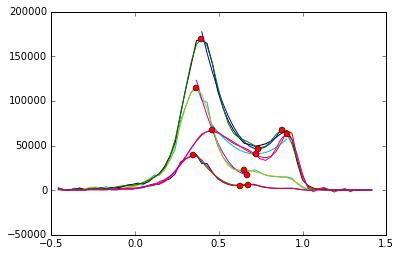

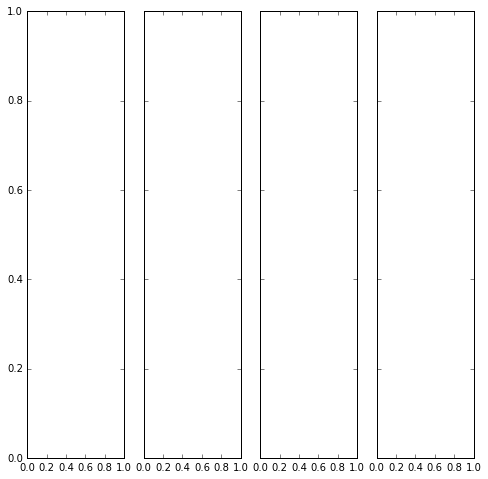

In [4]:
bzd = Ministry(0.3, 0.7, 0.7, 0.0, 2.0, 3*53.71)
bzdmetrics = [Richness(bzd, splitinfo=True,lightcone=True,zbins=np.logspace(-1,np.log10(2),5),colorbins=60)]#,Richness(bzd,colorbins=50)]
files = glob('/u/ki/jderose/desims/addgals/catalogs/Buzzard/Catalog_v1.1/truth/Buzzard_v1.1_truth.*.fit')
bfs = {}
bfs['truth'] = files[:1]
bzd.setGalaxyCatalog('BCC', bfs, fieldmap=fm, unitmap={'halomass':'msunh'})
bzd.galaxycatalog.metrics = bzdmetrics
bzd.validate()
for m in bzd.metrics:
    f, ax, l1 = m.visualize()
    f.suptitle('Buzzard 1.1 Richness',fontsize=14)

In [ ]:
bzd10 = Ministry(0.3, 0.7, 0.7, 0.0, 2.0, 3*53.71)
bzdmetrics10 = [Richness(bzd10, splitinfo=True,lightcone=True,zbins=np.logspace(-1,np.log10(2),5),colorbins=60)]
files10 = glob('/nfs/slac/g/ki/ki19/des/mbusha/catalogs/Buzzard/Catalog_v1.0/truth/Chinchilla-1_v1.0_truth.*.fit')
bfs10 = {}
bfs10['truth'] = files10[:1]
bzd10.setGalaxyCatalog('BCC', bfs10, fieldmap=fm, unitmap={'halomass':'msunh'})
bzd10.galaxycatalog.metrics = bzdmetrics10
bzd10.validate()
for m in bzd10.metrics:
    m.visualize()

In [ ]:
filesch = glob('/nfs/slac/g/ki/ki23/des/jderose/BCC/Chinchilla/Herd/Chinchilla-1/addgalspostprocess/truth_rotated_Y1a/Chinchilla-1Y1a_v1.2_truth.fits.*.fits')
chfs = {}
chfs['truth'] = filesch[:1]
ch = Ministry(0.3, 0.7, 0.7, 0.0, 2.0, 3*53.71)
chmetrics = [Richness(ch, splitinfo=True,lightcone=True,zbins=np.logspace(-1,np.log10(2),5),colorbins=60)]
ch.setGalaxyCatalog('BCC', chfs, fieldmap=fm, unitmap={'halomass':'msunh'})
ch.galaxycatalog.metrics = chmetrics
ch.validate()
ch.metrics[0].visualize()

In [ ]:
files10

In [ ]:
fig, ax = bzd.metrics[0].compare([bzd.metrics[0],bzd10.metrics[0], ch.metrics[0]], xlim=[10**10.7, 10**15.3])
fig.suptitle(r'Buzzard Richness by Halo Mass',fontsize=18)
zbins=np.logspace(-1,np.log10(2),5)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(len(ax[0])):
    ax[0,i].set_title(r"Redshift $[10^{%05.3f},10^{%05.3f}]$" % (np.log10(zbins[i]), np.log10(zbins[i+1])))
ax[1,0].set_ylabel('1.0 Residues')
fig.set_size_inches(20,8)

In [ ]:
%pdb

In [ ]:
ax[0]

In [ ]:
for i in range(3):
    print(i)
print(i)

In [ ]:
np.log10(10)

In [ ]:
dum = np.array([4,2,15,3,1,14,18,0])
dum[np.argpartition(dum, -1)][-2:]

In [ ]:
dum1 = np.array([4,2,15,3,1,14,18,0])
dum2 = np.array([1,2,15,3,1,14,18,0])
np.where(dum1[1] == dum2)

In [ ]:
np.find(dum1, 15)

In [ ]:
tester =5
type(tester)==int

In [ ]:
vec = np.array([1,0,0,1,235])
vec[True]

In [ ]:
np.logspace(10,16,2)

In [ ]:
thing=np.zeros((2,2,2))
np.shape(thing)

In [ ]:
f = plt.plot([1,2],[1,2])


In [ ]:
plt.title(f,'het')